# Volatility Nowcasting from Market Data + News

**Goal:** Predict next-H-day realized variance (RV) of the S&P 500 (default H=5) from past market features and daily-pooled news signals. Outputs are interpretable as annualized volatility.

**Target & Horizon**
- Target: RV_H = Σ_{t+1..t+H} r_τ^2 (close-to-close); the regression target is log(1+RV_H).
- Horizon: next H trading days (default 5).

**Data Sources**
- Prices: Yahoo Finance (OHLCV, 1d).
- News: CSV of timestamped texts (see CFG["news_csv_path"]).
- Embeddings: sentence-transformers/all-MiniLM-L6-v2.
- Sentiment: ProsusAI/finbert.

**Leakage Guards**
- News timestamps → America/New_York; only items ≤ 16:00 ET are eligible.
- Each calendar day mapped to next trading day; features aggregated on that traded day.
- Expanding time splits with embargo and purge around the horizon.
- Alignment checks that assert “no look-ahead”.

**Features**
- Market: short/medium returns, rolling vols, intraday range.
- News: FinBERT sentiment stats per traded day (+ rolling windows), pooled text embeddings (PCA) [optional; lean set uses only rolling sentiment features for generalization].

**Evaluation**
- R², RMSE/MAE on log(1+RV_H), Spearman IC, and QLIKE on RV (↓ better).
- Comparative: Tech-only vs Tech+News vs News-only and HAR baseline.
- Rolling R²/IC plots, calibration curve, feature importance & permutation stability.

**Assumptions & Limits**
- Single index (^GSPC by default).
- Uneven news coverage; per-day cap K mitigates spikes.
- Nowcasting short-horizon risk — not directional price bets.

**Reproducibility**
- Fixed seeds, environment stamp, cached heavy steps, GPU optional.


In [1]:
# --- Data paths & cache options ---
# If you want to run this notebook yourself:
#   - Download the raw 6 GB file `All_external.csv` from HuggingFace:
#       https://huggingface.co/datasets/Zihan1004/FNSPID/tree/main/Stock_news
#   - Put it into your own Google Drive under `/MyDrive/data/`
#   - The notebook will then build/use compact daily features from it.
#
# CFG["rebuild_daily_cache"]:
#   - False → use existing compact cache if available (faster, typical for re-runs).
#   - True  → force rebuild compact features (FinBERT sentiment + embeddings) from raw All_external.csv.
#             This is very slow and should only be done once, or if you change parameters.

# --- Colab/Env setup ---
import os
import warnings
import json
import math
import importlib
import platform
import sys
import datetime as dt
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import torch
from google.colab import drive
drive.mount("/content/drive")

# --- Project Config ---
CFG = {
    # Data
    "ticker": "^GSPC",
    "start": "2012-01-01",
    "end":   None,
    "price_interval": "1d",

    # Vol target
    "vol_horizon_days": 5,
    "log1p_target": True,          # y = log(1 + RV_H)
    "high_vol_q": 0.80,

    # News
    "max_news_per_day": 100,
    "rolling_news_windows": [3,5,10],
    "embed_model": "sentence-transformers/all-MiniLM-L6-v2",
    "sentiment_model": "ProsusAI/finbert",
    "use_ny_cutoff": True,

    # Training / CV
    "seed": 42,
    "n_splits": 5,
    "inner_val_days": 126,

    # Caching & runtime
    "rebuild_daily_cache": True,

    # Paths (adapt to your Drive)
    "news_csv_path": "/content/drive/MyDrive/data/All_external.csv",
    "news_compact_cache": "/content/drive/MyDrive/data/news_snp500_compact.csv",
    "model_out_dir": "/content/drive/MyDrive/models/vol_xgb",
}

SEED = int(CFG["seed"])
rng = np.random.default_rng(SEED)
use_gpu = torch.cuda.is_available()
print("GPU available:", use_gpu)

# --- Environment stamp (for reproducibility) ---
def _ver(pkg):
    try: return importlib.import_module(pkg).__version__
    except Exception: return "n/a"

try:
    gpu = torch.cuda.is_available()
    gpu_name = torch.cuda.get_device_name(0) if gpu else "CPU"
    cuda_ver = torch.version.cuda if hasattr(torch, "version") else "n/a"
except Exception:
    gpu, gpu_name, cuda_ver = False, "CPU", "n/a"

stamp = {
    "Run (UTC)": dt.datetime.utcnow().isoformat(timespec="seconds")+"Z",
    "Python": sys.version.split()[0],
    "Platform": platform.platform(),
    "Seed": SEED,
    "GPU": gpu,
    "GPU name": gpu_name,
    "CUDA": cuda_ver,
    "numpy": _ver("numpy"),
    "pandas": _ver("pandas"),
    "sklearn": _ver("sklearn"),
    "xgboost": _ver("xgboost"),
    "transformers": _ver("transformers"),
    "sentence-transformers": _ver("sentence_transformers"),
    "datasets": _ver("datasets"),
    "yfinance": _ver("yfinance"),
}
for k,v in stamp.items(): print(f"{k:>16}: {v}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 64.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml-cu12 25.6.0 requires scikit-learn>=1.5, but you have scikit-learn 1.4.2 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.
Mounted at /content/drive
GPU available: True
       Run (UTC): 2025-09-27T10:55:33Z
          Python: 3.12.11
        Platform: Linux-6.6.97+-x86_64-with-glibc2.35
            Seed: 42
             GPU: True
        GPU name: Tesla T4
            CUDA: 12.6
           numpy: 2.0.2
          pandas: 2.2.2
         sklearn: 1.4.2
         xgboost: 2.0.3
    transformers: 4.56.1
sentence-transformers: 5.1.0
        datasets: 4.0.0
        yfinance: 0.2.66


In [2]:
import yfinance as yf

def _flatten_cols(cols):
    if isinstance(cols, pd.MultiIndex):
        return ["_".join([str(c) for c in col if c not in (None,""," ")]).strip().lower()
                for col in cols.to_list()]
    return [str(c).lower() for c in cols]

def _pick(df, candidates):
    for c in candidates:
        if c in df.columns: return c
    for col in df.columns:
        for c in candidates:
            if col.endswith("_"+c) or col.startswith(c+"_") or col == c.replace(" ","_"):
                return col
    for col in df.columns:
        for c in candidates:
            if c.replace(" ","_") in col: return col
    raise KeyError(f"None of {candidates} in columns: {df.columns.tolist()}")

def load_prices(ticker, start=None, end=None, interval="1d", auto_adjust=True, progress=False):
    df = yf.download(ticker, start=start, end=end, interval=interval,
                     auto_adjust=auto_adjust, progress=progress)
    if df is None or len(df)==0: raise ValueError(f"No data for {ticker}.")
    df = df.reset_index()
    df.columns = _flatten_cols(df.columns)
    if "date" not in df.columns:
        if "datetime" in df.columns: df = df.rename(columns={"datetime":"date"})
        elif "index" in df.columns:  df = df.rename(columns={"index":"date"})
        else:
            time_like = next((c for c in df.columns if "date" in c or "time" in c), None)
            if not time_like: raise KeyError("No 'date' column found.")
            df = df.rename(columns={time_like:"date"})
    df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None)

    open_col   = _pick(df, ["open"])
    high_col   = _pick(df, ["high"])
    low_col    = _pick(df, ["low"])
    try: close_col = _pick(df, ["close"])
    except KeyError: close_col = _pick(df, ["adj close","adj_close","close_adj"])
    volume_col = _pick(df, ["volume"])

    df = df.rename(columns={
        open_col:"open", high_col:"high", low_col:"low",
        close_col:"close", volume_col:"volume"
    })
    df = df[["date","open","high","low","close","volume"]].sort_values("date").reset_index(drop=True)
    return df

px = load_prices(CFG["ticker"], start=CFG["start"], end=CFG["end"], interval=CFG["price_interval"])

# technicals
px["ret_1"]  = px["close"].pct_change(1)
px["ret_5"]  = px["close"].pct_change(5)
px["ret_21"] = px["close"].pct_change(21)
px["vol_5"]  = px["ret_1"].rolling(5).std()
px["vol_21"] = px["ret_1"].rolling(21).std()
px["range"]  = (px["high"] - px["low"]) / px["close"]

# next-H day realized variance (sum of next H squared daily returns)
H = int(CFG["vol_horizon_days"])
rv_1 = px["ret_1"]**2
px[f"rv_fwd_{H}"] = rv_1.rolling(H).sum().shift(-H)

if CFG["log1p_target"]:
    px[f"log_rv_{H}"] = np.log1p(px[f"rv_fwd_{H}"])
    TARGET_COL = f"log_rv_{H}"
else:
    TARGET_COL = f"rv_fwd_{H}"

px = px.dropna().reset_index(drop=True)
print("Price rows:", len(px), "| target:", TARGET_COL)

Price rows: 3428 | target: log_rv_5


In [3]:
from tqdm.auto import tqdm

NEWS_CSV   = CFG["news_csv_path"]
NEWS_CACHE = CFG["news_compact_cache"]

def _pick_col(cols, candidates):
    cl = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in cl: return cl[cand.lower()]
    for c in cols:
        lc = c.lower()
        for cand in candidates:
            if cand.lower() in lc: return c
    return None

def load_news_chunked(csv_path, date_min, date_max, cache_path=None, chunksize=400_000):
    date_min = pd.to_datetime(date_min, utc=True).tz_convert(None)
    date_max = pd.to_datetime(date_max, utc=True).tz_convert(None)

    if cache_path and os.path.exists(cache_path):
        print(f"Loading cached compact news: {cache_path}")
        df = pd.read_csv(cache_path)
        df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True).dt.tz_convert(None)
        df = df.dropna(subset=["date","text"]).sort_values("date").reset_index(drop=True)
        return df[(df["date"]>=date_min)&(df["date"]<=date_max)].reset_index(drop=True)

    header = pd.read_csv(csv_path, nrows=0)
    cols = header.columns.tolist()
    date_col = _pick_col(cols, ["date","datetime","published_at","time","timestamp","pub_time"])
    text_col = _pick_col(cols, ["text","headline","title","content","summary","article"])
    if date_col is None or text_col is None:
        raise ValueError(f"Could not find date/text columns. Found: {cols[:20]}")

    keep = []
    scanned, kept = 0, 0
    for chunk in pd.read_csv(csv_path, usecols=[date_col,text_col], chunksize=chunksize, low_memory=False):
        scanned += len(chunk)
        chunk = chunk.rename(columns={date_col:"date", text_col:"text"})
        chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce", utc=True).dt.tz_convert(None)
        chunk = chunk.dropna(subset=["date","text"])
        chunk["text"] = chunk["text"].astype(str).str.strip()
        chunk = chunk[chunk["text"].str.len() > 0]
        chunk = chunk[(chunk["date"] >= date_min) & (chunk["date"] <= date_max)]
        keep.append(chunk)
        kept += len(chunk)
        if scanned % (2_000_000) < chunksize:
            print(f"Scanned ~{scanned:,} | kept ~{kept:,}")

    news = pd.concat(keep, ignore_index=True) if keep else pd.DataFrame(columns=["date","text"])
    before = len(news)
    news = news.drop_duplicates(subset=["date","text"]).sort_values("date").reset_index(drop=True)
    print(f"Loaded news rows: {before:,} → {len(news):,} (dedup).")

    if cache_path:
        os.makedirs(os.path.dirname(cache_path), exist_ok=True)
        news.to_csv(cache_path, index=False)
        print("Wrote compact cache →", cache_path)
    return news

if os.path.exists(NEWS_CSV):
    news = load_news_chunked(
        NEWS_CSV, date_min=px["date"].min(), date_max=px["date"].max(),
        cache_path=NEWS_CACHE, chunksize=300_000
    )
else:
    print("No news file found. Creating a small synthetic sample.")
    dates = pd.date_range(px["date"].min(), px["date"].max(), freq="D")
    texts = ["Tech leads gains","Caution ahead of Fed","Energy drags","Earnings surprise","Risk-off on geopolitics"]
    news = pd.DataFrame({"date": rng.choice(dates, size=2000),
                         "text": rng.choice(texts, size=2000)})

news["date"] = pd.to_datetime(news["date"], errors="coerce", utc=True).dt.tz_convert(None)
news = news.dropna(subset=["date","text"]).sort_values("date").reset_index(drop=True)
news["date_only"] = news["date"].dt.date
news = news.groupby("date_only").head(int(CFG["max_news_per_day"])).reset_index(drop=True)
print("News rows after per-day cap:", len(news))

Loading cached compact news: /content/drive/MyDrive/data/news_snp500_compact.csv
News rows after per-day cap: 300721


In [4]:
import os
import time
from datetime import time as dtime
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from datasets import Dataset as HFDataset
from transformers.pipelines.pt_utils import KeyDataset

os.environ["TOKENIZERS_PARALLELISM"] = "true"
use_gpu   = torch.cuda.is_available()
device_id = 0 if use_gpu else -1

K         = max(10, min(100, int(CFG.get("max_news_per_day", 50))))
MAX_LEN   = 96
SENT_BS   = 512 if use_gpu else 64
EMB_BS    = 512 if use_gpu else 64
PCA_DIMS  = 16
FORCE_REBUILD = bool(CFG["rebuild_daily_cache"])

DATA_DIR   = "/content/drive/MyDrive/data"
SENT_CACHE = f"{DATA_DIR}/daily_sentiment_TRAD_v2_k{K}_len{MAX_LEN}.csv"
EMB_CACHE  = f"{DATA_DIR}/daily_embeddings_TRAD_v2_k{K}_pca{PCA_DIMS}.csv"

print(f"GPU: {use_gpu} | K={K} | MAX_LEN={MAX_LEN}")

# 3.1 NY cutoff & map calendar → next trading day
ts = pd.to_datetime(news["date"], errors="coerce")
if getattr(ts.dtype, "tz", None) is not None:
    dt_ny = ts.dt.tz_convert("America/New_York")
else:
    ts_noon = ts.dt.normalize() + pd.Timedelta(hours=12)
    dt_ny = ts_noon.dt.tz_localize("America/New_York", nonexistent="shift_forward")

news = news.copy()
news["date_only_ny"] = dt_ny.dt.normalize().dt.tz_localize(None)
news["time_ny"]      = dt_ny.dt.time
news["text"]         = news["text"].astype(str).str.strip()
news = news.dropna(subset=["date_only_ny","time_ny","text"]).drop_duplicates(subset=["date_only_ny","text"])
if CFG.get("use_ny_cutoff", True):
    news = news.loc[news["time_ny"] <= dtime(16,0)]
news = news.sort_values(["date_only_ny","time_ny"]).groupby("date_only_ny", sort=False).head(K).reset_index(drop=True)
news["text"] = news["text"].str.slice(0, 280)
print("Capped rows:", len(news), "| unique NY days:", news["date_only_ny"].nunique())

px_dates = pd.to_datetime(px["date"]).dt.normalize().drop_duplicates().sort_values()
px_int = px_dates.view("int64").to_numpy()

def map_next_trading_day(d):
    i = np.searchsorted(px_int, np.int64(pd.Timestamp(d).value))
    if i >= len(px_int): return pd.NaT
    return pd.Timestamp(px_int[i]).tz_localize(None)

news["date_only_traded"] = news["date_only_ny"].map(map_next_trading_day)
news = news.dropna(subset=["date_only_traded"]).reset_index(drop=True)

# Optional cache nuke if logic changes
if FORCE_REBUILD:
    for pth in (SENT_CACHE, EMB_CACHE):
        if os.path.exists(pth):
            os.remove(pth); print("Deleted cache:", pth)

# 3.2 FinBERT daily sentiment per traded day
if os.path.exists(SENT_CACHE) and not FORCE_REBUILD:
    daily_sent = pd.read_csv(SENT_CACHE, parse_dates=["date_only"])
    print("Loaded sentiment cache.")
else:
    print("Building FinBERT sentiment…")
    model_id = CFG["sentiment_model"]
    tok   = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_id)
    if use_gpu: model = model.half().to("cuda")

    sent_pipe = pipeline(
        "text-classification",
        model=model, tokenizer=tok, device=device_id,
        truncation=True, padding="max_length", max_length=MAX_LEN,
        top_k=1, return_all_scores=False,
    )
    ds = HFDataset.from_pandas(news[["text"]], preserve_index=False)

    def decode(o):
        if isinstance(o, list): o = max(o, key=lambda d: d.get("score", -1.0)) if o else {}
        lab = str(o.get("label","")).lower()
        val = 1 if "pos" in lab else (-1 if "neg" in lab else 0)
        return val, float(o.get("score", 0.0))

    vals, confs = [], []
    for out in tqdm(sent_pipe(KeyDataset(ds, "text"), batch_size=SENT_BS),
                    total=len(ds), desc="FinBERT"):
        v, s = decode(out); vals.append(v); confs.append(s)

    tmp = news.copy()
    tmp["sentiment_cls"]  = np.array(vals,  dtype=np.int8)
    tmp["sentiment_conf"] = np.array(confs, dtype=np.float32)

    daily_sent = (tmp.groupby("date_only_traded").agg(
        n_news=("text","count"),
        sent_mean=("sentiment_cls","mean"),
        sent_pos_ratio=("sentiment_cls", lambda s: (s>0).mean()),
        sent_neg_ratio=("sentiment_cls", lambda s: (s<0).mean()),
        sent_conf_mean=("sentiment_conf","mean"),
    ).reset_index().rename(columns={"date_only_traded":"date_only"}))

    os.makedirs(os.path.dirname(SENT_CACHE), exist_ok=True)
    daily_sent.to_csv(SENT_CACHE, index=False)
    print("Wrote:", SENT_CACHE)

# 3.3 Sentence embeddings → PCA per traded day (optional)
if os.path.exists(EMB_CACHE) and not FORCE_REBUILD:
    daily_emb_pca = pd.read_csv(EMB_CACHE, parse_dates=["date_only"])
    print("Loaded embeddings cache.")
else:
    pooled = (news.groupby("date_only_traded")["text"]
                  .apply(lambda s: " [SEP] ".join(map(str, s))).reset_index()
                  .rename(columns={"date_only_traded":"date_only"}))

    print("Encoding pooled texts with SentenceTransformer…")
    embedder = SentenceTransformer(CFG["embed_model"], device=("cuda" if use_gpu else "cpu"))
    embedder.max_seq_length = MAX_LEN
    E = embedder.encode(pooled["text"].tolist(), batch_size=EMB_BS,
                        convert_to_numpy=True, normalize_embeddings=True,
                        show_progress_bar=True)

    emb_cols = [f"embd_{i}" for i in range(E.shape[1])]
    daily_emb = pd.concat([pooled[["date_only"]], pd.DataFrame(E, columns=emb_cols)], axis=1)

    pca = PCA(n_components=PCA_DIMS, random_state=SEED)
    Z = pca.fit_transform(daily_emb[emb_cols].values)
    pca_cols = [f"emb_pca_{i}" for i in range(Z.shape[1])]
    daily_emb_pca = pd.concat([daily_emb[["date_only"]], pd.DataFrame(Z, columns=pca_cols)], axis=1)

    daily_emb_pca.to_csv(EMB_CACHE, index=False)
    print("Wrote:", EMB_CACHE)

# 3.4 Merge to daily (traded-day keyed)
daily = (pd.merge(daily_sent, daily_emb_pca, on="date_only", how="left")
           .sort_values("date_only").reset_index(drop=True))
print("Daily shape:", daily.shape, "| date span:", daily["date_only"].min(), "→", daily["date_only"].max())

GPU: True | K=100 | MAX_LEN=96
Capped rows: 300383 | unique NY days: 3053
Loaded sentiment cache.
Loaded embeddings cache.
Daily shape: (2103, 22) | date span: 2012-02-02 00:00:00 → 2020-06-11 00:00:00


In [5]:
def to_utc_naive(s):  # robust parser
    return pd.to_datetime(s, errors="coerce", utc=True).dt.tz_convert(None)

feat = px.copy(deep=True)
feat["date"]      = to_utc_naive(feat["date"])
feat["date_only"] = feat["date"].dt.normalize()
px_days = np.unique(feat["date_only"].to_numpy(dtype="datetime64[D]"))

d2 = daily.copy()
d2["date_only"] = to_utc_naive(d2["date_only"]).dt.normalize()

def map_to_next_trading_day(d_series, trading_days_days):
    d_norm = to_utc_naive(d_series).dt.normalize()
    d_days = d_norm.to_numpy(dtype="datetime64[D]")
    td     = np.asarray(trading_days_days, dtype="datetime64[D]")
    idx = np.searchsorted(td, d_days, side="left")
    mapped = np.full(d_days.shape, np.datetime64("NaT","D"), dtype="datetime64[D]")
    ok = idx < td.shape[0]
    mapped[ok] = td[idx[ok]]
    return pd.to_datetime(mapped.astype("datetime64[ns]"))

d2["date_only_traded"] = map_to_next_trading_day(d2["date_only"], px_days)
d2 = d2.dropna(subset=["date_only_traded"]).reset_index(drop=True)

# trim feature window to where mapped news exists
win_start, win_end = d2["date_only_traded"].min(), d2["date_only_traded"].max()
feat = feat.loc[(feat["date_only"] >= win_start) & (feat["date_only"] <= win_end)].reset_index(drop=True)

# merge news onto the trading day it becomes tradable
pca_cols = [c for c in d2.columns if c.startswith("emb_pca_")]
sent_cols = ["n_news","sent_mean","sent_pos_ratio","sent_neg_ratio","sent_conf_mean"]
merge_cols = ["date_only_traded", *sent_cols, *pca_cols]
d_merge = d2[merge_cols].rename(columns={"date_only_traded":"date_only"})
feat = feat.merge(d_merge, on="date_only", how="left").sort_values("date").reset_index(drop=True)

# neutral fill & dtype
for c in sent_cols:
    if c in feat.columns:
        feat[c] = feat[c].fillna(0.0).astype("float32")
if pca_cols:
    feat[pca_cols] = feat[pca_cols].fillna(0.0).astype("float32")

# rollups (past-only; features already time-shifted to tradable day)
roll_ws = list(CFG["rolling_news_windows"])
for w in roll_ws:
    feat[f"n_news_roll{w}"]    = feat["n_news"].rolling(w, min_periods=1).sum().astype("float32")
    feat[f"sent_mean_roll{w}"] = feat["sent_mean"].rolling(w, min_periods=1).mean().astype("float32")
    feat[f"sent_posr_roll{w}"] = feat["sent_pos_ratio"].rolling(w, min_periods=1).mean().astype("float32")
    feat[f"sent_negr_roll{w}"] = feat["sent_neg_ratio"].rolling(w, min_periods=1).mean().astype("float32")
    feat[f"sent_conf_roll{w}"] = feat["sent_conf_mean"].rolling(w, min_periods=1).mean().astype("float32")

feat = feat.dropna(subset=["date"]).reset_index(drop=True)
share_news = (feat["n_news"] > 0).mean() if "n_news" in feat.columns else 0.0
print(f"[Window] {feat['date'].min().date()} → {feat['date'].max().date()} | rows={len(feat)} | share with news={share_news:.2%}")

base_mkt_feats = ["ret_1","ret_5","ret_21","vol_5","vol_21","range"]
news_roll      = [c for c in feat.columns if (c.startswith("n_news_roll") or (c.startswith("sent_") and "_roll" in c)) and "pca" not in c]
X_cols         = list(dict.fromkeys(base_mkt_feats + news_roll))
print("Using lean feature set:", len(X_cols), "features")

[Window] 2012-02-02 → 2020-06-11 | rows=2103 | share with news=100.00%
Using lean feature set: 21 features


In [6]:
# 0) Basic hygiene
feat["date_only"] = pd.to_datetime(feat["date_only"], errors="coerce")
assert feat["date_only"].notna().all(), "NaT in feat['date_only']."

px_days_idx = pd.to_datetime(px["date"], errors="coerce").dt.normalize()
px_days_idx = pd.Index(px_days_idx.dropna().unique()).sort_values()
px_days_np  = px_days_idx.to_numpy(dtype="datetime64[D]")

# 1) News cutoff guard
if "news" in globals() and "time_ny" in news.columns:
    assert (news["time_ny"].dropna() <= pd.to_datetime("16:00").time()).all(), "News after 16:00 ET found."

# 2) If features show news, that day must be a trading day
if "n_news" in feat.columns:
    used_days = pd.to_datetime(feat.loc[feat["n_news"]>0, "date_only"]).dt.normalize().to_numpy(dtype="datetime64[D]")
    missing = np.setdiff1d(used_days, px_days_np, assume_unique=False)
    assert len(missing) == 0, "Some news-feature days not in trading calendar."

# 3) Target alignment check (recompute from returns)
H = int(CFG["vol_horizon_days"])
ret1_sq = (feat["ret_1"].astype(float) ** 2)
rv_fwd_check = ret1_sq.rolling(H).sum().shift(-H)
tgt_check = np.log1p(rv_fwd_check) if CFG["log1p_target"] else rv_fwd_check

cmp_df = pd.DataFrame({"tgt": feat[f"log_rv_{H}" if CFG["log1p_target"] else f"rv_fwd_{H}"], "chk": tgt_check}).replace([np.inf,-np.inf], np.nan).dropna()
if not cmp_df.empty:
    ok = np.allclose(cmp_df["tgt"].to_numpy(), cmp_df["chk"].to_numpy(), rtol=1e-8, atol=1e-8)
    assert ok, "Target misaligned. Check shifts."

# 4) Rollups recompute check
import re
roll_cols = [c for c in feat.columns if c.startswith(("n_news_roll","sent_mean_roll","sent_posr_roll","sent_negr_roll","sent_conf_roll"))]
def _recompute_roll(col_name):
    m = re.search(r"roll(\d+)", col_name); assert m
    w = int(m.group(1))
    if col_name.startswith("n_news_roll"): base, reducer = "n_news","sum"
    elif col_name.startswith("sent_mean_roll"): base, reducer = "sent_mean","mean"
    elif col_name.startswith("sent_posr_roll"): base, reducer = "sent_pos_ratio","mean"
    elif col_name.startswith("sent_negr_roll"): base, reducer = "sent_neg_ratio","mean"
    elif col_name.startswith("sent_conf_roll"): base, reducer = "sent_conf_mean","mean"
    s = feat[base].astype("float64")
    return s.rolling(w, min_periods=1).sum() if reducer=="sum" else s.rolling(w, min_periods=1).mean()
for c in roll_cols:
    rec = _recompute_roll(c).astype("float64")
    cur = feat[c].astype("float64")
    both = pd.concat([rec, cur], axis=1).replace([np.inf,-np.inf], np.nan).dropna()
    if not both.empty:
        assert np.allclose(both.iloc[:,0], both.iloc[:,1], rtol=1e-6, atol=1e-7), f"Rollup mismatch: {c}"

# 5) All feature days must be trading days
feat_days = pd.Index(pd.to_datetime(feat["date_only"]).dt.normalize().unique()).sort_values()
missing_feat_days = np.setdiff1d(feat_days.to_numpy(dtype="datetime64[D]"), px_days_np, assume_unique=False)
assert len(missing_feat_days) == 0, "feat contains dates not in trading calendar."

print("[Guards] Passed all alignment checks.")

[Guards] Passed all alignment checks.


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = (feat[X_cols].select_dtypes("number")
                 .astype("float32")
                 .replace([np.inf,-np.inf], np.nan)
                 .fillna(0.0)
                 .reset_index(drop=True))

target_name = f"log_rv_{H}" if CFG["log1p_target"] else f"rv_fwd_{H}"
y = feat[target_name].astype("float32").reset_index(drop=True)

# (placeholder; trees don't need scaling)
preprocess = ColumnTransformer([("num", Pipeline([("scaler", StandardScaler())]), X_cols)], remainder="drop")

def purged_expanding_splits(n, n_splits=5, min_train=500, horizon=5, embargo=2):
    edges = np.linspace(min_train, n-1, n_splits+1, dtype=int)
    for i in range(n_splits):
        tr_end, te_end = edges[i], edges[i+1]
        tr_end_purged = max(0, tr_end - horizon)
        te_start = tr_end + embargo
        tr_idx = np.arange(0, tr_end_purged)
        te_idx = np.arange(te_start, te_end)
        if len(te_idx)>0 and len(tr_idx)>=min_train:
            yield tr_idx, te_idx

splits = list(purged_expanding_splits(len(X),
                                      n_splits=int(CFG["n_splits"]),
                                      min_train=500,
                                      horizon=H,
                                      embargo=2))
print("Splits (train/test sizes):", [tuple(map(len, s)) for s in splits])
assert splits, "Not enough data for splits."

Splits (train/test sizes): [(815, 318), (1135, 319), (1456, 318), (1776, 319)]


In [8]:
# --- XGBoost training/eval (XGBoost 3.x: use device="cuda" instead of gpu_hist) ---
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr

def dmat(A, b=None):
    Xa = np.ascontiguousarray(A.values, np.float32)
    ya = None if b is None else np.asarray(b.values, np.float32)
    return xgb.DMatrix(Xa, label=ya, feature_names=list(A.columns))

USE_GPU = torch.cuda.is_available()  # True if a CUDA GPU (e.g., T4) is attached

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.03,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": SEED,
    "tree_method": "hist",                   # unified tree method
    "device": "cuda" if USE_GPU else "cpu",  # key change for XGBoost >= 2.0/3.x
    # no "predictor" needed in 3.x
}

VAL_WIN = int(CFG["inner_val_days"])

oof = np.full(len(X), np.nan, dtype=np.float32)
models, best_iters = [], []

for k, (tr, te) in enumerate(splits, 1):
    tr_end = tr[-1] + 1
    v0 = max(tr[0], tr_end - VAL_WIN)
    tr_core = np.arange(tr[0], v0)
    va_in   = np.arange(v0, tr_end)

    bst = xgb.train(
        params,
        dmat(X.iloc[tr_core], y.iloc[tr_core]),
        num_boost_round=3000,
        evals=[(dmat(X.iloc[va_in], y.iloc[va_in]), "valid")],
        early_stopping_rounds=150,
        verbose_eval=False,
    )
    best_it = int(getattr(bst, "best_iteration", 0))
    oof[te] = bst.predict(
        dmat(X.iloc[te]),
        iteration_range=(0, best_it + 1)
    ).astype(np.float32)

    models.append(bst)
    best_iters.append(best_it)
    print(f"[Fold {k}] rounds={best_it}  te={len(te)}")

# --- Metrics ---
mask = np.isfinite(oof)
y_m  = y[mask]
p_m  = oof[mask]

R2 = r2_score(y_m, p_m)
try:
    RMSE = mean_squared_error(y_m, p_m, squared=False)
except TypeError:
    RMSE = float(np.sqrt(mean_squared_error(y_m, p_m)))
MAE = mean_absolute_error(y_m, p_m)
IC  = spearmanr(y_m, p_m, nan_policy="omit").correlation

print(f"\nOOF on {target_name}:")
print(f"  R²={R2:.3f}   RMSE={RMSE:.6f}   MAE={MAE:.6f}   Spearman(IC)={IC:.3f}   n={mask.sum():,}")

# Interpretable last prediction → annualized vol
last_pred = float(p_m[-1])
rvH_pred = math.expm1(last_pred) if CFG["log1p_target"] else last_pred
sigma_daily = np.sqrt(max(rvH_pred, 0.0) / H)
ann_vol = sigma_daily * np.sqrt(252.0)
print(f"Latest pred → RV_{H}≈{rvH_pred:.6f} | σ_daily≈{sigma_daily:.2%} | σ_annual≈{ann_vol:.2%}")

[Fold 1] rounds=372  te=318
[Fold 2] rounds=88  te=319
[Fold 3] rounds=547  te=318
[Fold 4] rounds=256  te=319

OOF on log_rv_5:
  R²=0.114   RMSE=0.002460   MAE=0.000578   Spearman(IC)=0.622   n=1,274
Latest pred → RV_5≈0.000637 | σ_daily≈1.13% | σ_annual≈17.92%


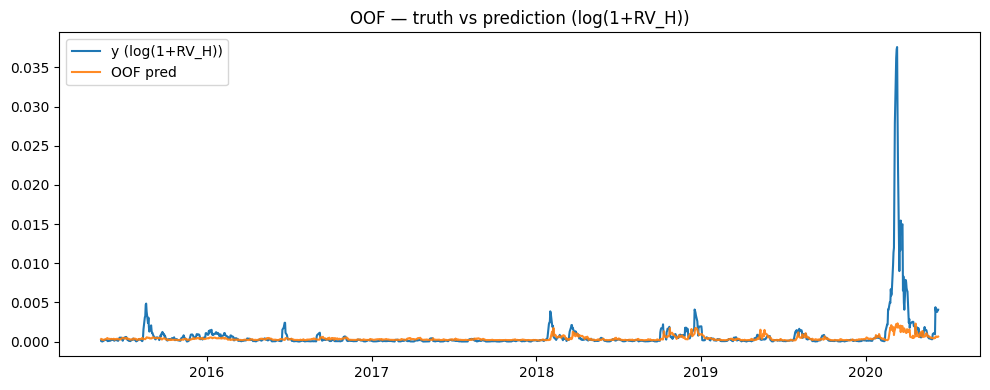

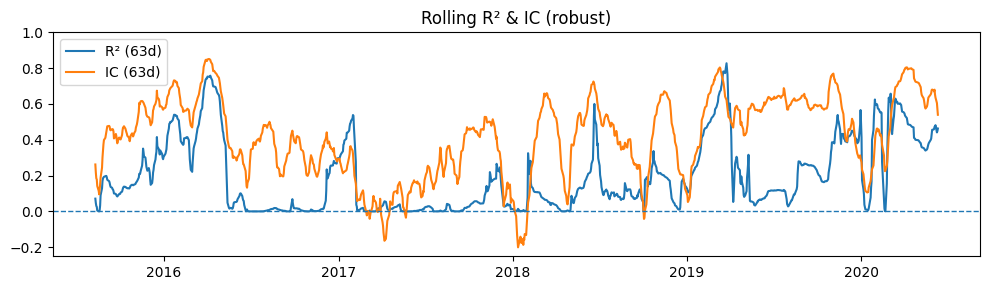

In [9]:
# === Robust rolling plots: OOF vs Truth, Rolling R² & IC (63d) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

mask = np.isfinite(oof)
plot_df = pd.DataFrame({
    "date": feat.loc[mask, "date"].values,
    "y":    y.loc[mask].values.astype(float),
    "pred": oof[mask].astype(float)
}).reset_index(drop=True)

win = 63  # rolling window

def roll_r2(y_arr, p_arr, w):
    """Robust rolling R² via corr^2 with variance guards; returns 0 if var≈0."""
    y = np.asarray(y_arr, float)
    p = np.asarray(p_arr, float)
    out = np.full(len(y), np.nan, float)
    for i in range(w-1, len(y)):
        ys = y[i-w+1:i+1]
        ps = p[i-w+1:i+1]
        m = np.isfinite(ys) & np.isfinite(ps)
        if m.sum() < max(5, int(0.8*w)):  # need enough points
            out[i] = np.nan
            continue
        ys = ys[m]; ps = ps[m]
        vy = np.var(ys)
        vp = np.var(ps)
        if vy <= 1e-12 or vp <= 1e-12:
            out[i] = 0.0  # flat series => define R²=0
            continue
        r = np.corrcoef(ys, ps)[0,1]
        out[i] = float(r*r)
    return out

def roll_ic(y_arr, p_arr, w):
    """Robust rolling Spearman rank corr (IC)."""
    out = np.full(len(y_arr), np.nan, float)
    for i in range(w-1, len(y_arr)):
        ys = y_arr[i-w+1:i+1]
        ps = p_arr[i-w+1:i+1]
        m = np.isfinite(ys) & np.isfinite(ps)
        if m.sum() < max(5, int(0.8*w)):
            out[i] = np.nan
            continue
        out[i] = pd.Series(ys[m]).corr(pd.Series(ps[m]), method="spearman")
    return out

plot_df["r2_rolling"] = roll_r2(plot_df["y"].values, plot_df["pred"].values, win)
plot_df["ic_rolling"] = roll_ic(plot_df["y"].values, plot_df["pred"].values, win)

# 1) OOF truth vs prediction (log(1+RV_H))
plt.figure(figsize=(10,4))
plt.plot(plot_df["date"], plot_df["y"],   label="y (log(1+RV_H))")
plt.plot(plot_df["date"], plot_df["pred"], label="OOF pred", alpha=0.9)
plt.title("OOF — truth vs prediction (log(1+RV_H))")
plt.legend(); plt.tight_layout(); plt.show()

# 2) Rolling metrics
plt.figure(figsize=(10,3))
plt.plot(plot_df["date"], plot_df["r2_rolling"], label=f"R² ({win}d)")
plt.plot(plot_df["date"], plot_df["ic_rolling"], label=f"IC ({win}d)")
plt.axhline(0.0, ls="--", lw=1)
plt.ylim(bottom=min(-0.05, np.nanmin(plot_df["ic_rolling"])-0.05), top=max(1.0, np.nanmax(plot_df["r2_rolling"])+0.05))
plt.legend(); plt.title("Rolling R² & IC (robust)"); plt.tight_layout(); plt.show()

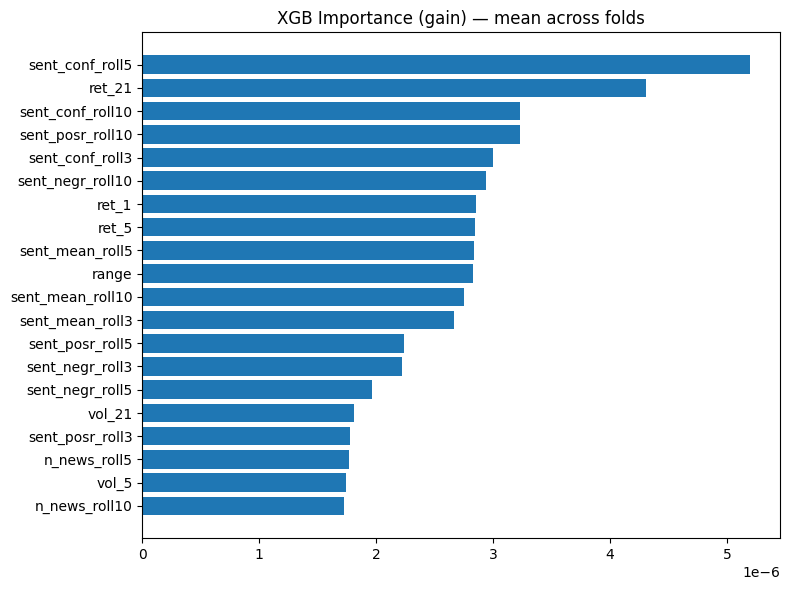

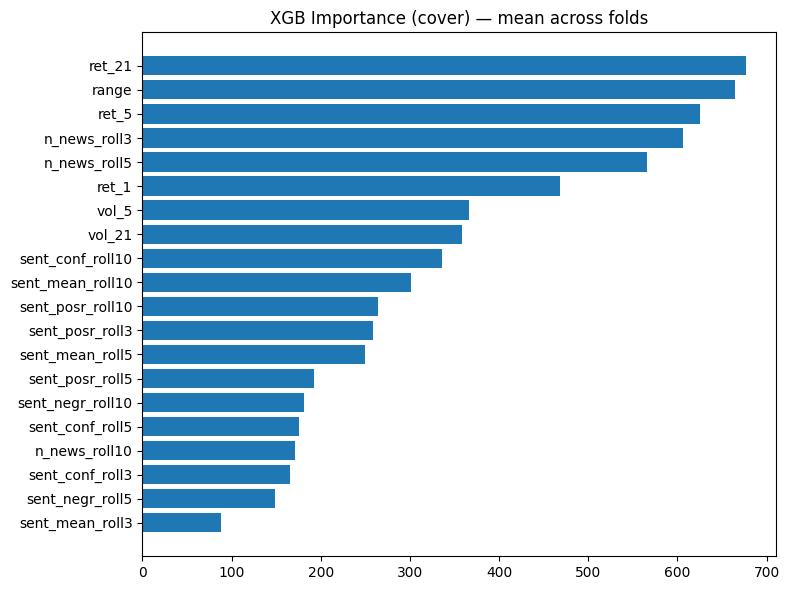

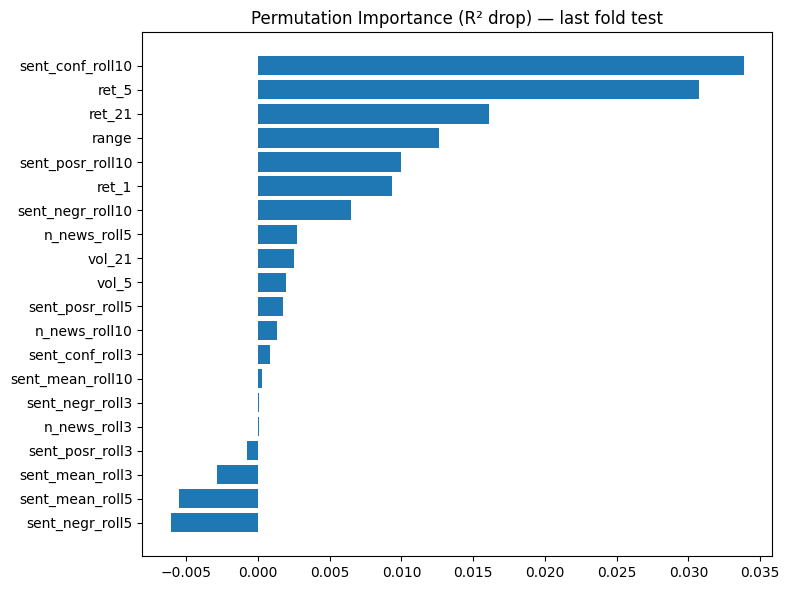

In [10]:
from sklearn.metrics import r2_score

def xgb_importance_aggregate(models, kind="gain"):
    frames = []
    for i, bst in enumerate(models, 1):
        imp = bst.get_score(importance_type=kind)
        df = pd.DataFrame({"feature": list(imp.keys()), kind: list(imp.values())})
        df["fold"] = i
        frames.append(df)
    out = pd.concat(frames, ignore_index=True)
    agg = (out.groupby("feature")[kind]
              .agg(["mean","std","count"])
              .sort_values("mean", ascending=False)
              .reset_index())
    return agg, out

gain_agg, _ = xgb_importance_aggregate(models, "gain")
cover_agg, _= xgb_importance_aggregate(models, "cover")

topK = 20
plt.figure(figsize=(8,6))
plt.barh(gain_agg["feature"].head(topK)[::-1], gain_agg["mean"].head(topK)[::-1])
plt.title("XGB Importance (gain) — mean across folds"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,6))
plt.barh(cover_agg["feature"].head(topK)[::-1], cover_agg["mean"].head(topK)[::-1])
plt.title("XGB Importance (cover) — mean across folds"); plt.tight_layout(); plt.show()

# Permutation on last fold test
last_fold = len(splits) - 1
tr_idx, te_idx = splits[last_fold]
X_test = X.iloc[te_idx].copy().reset_index(drop=True)
y_test = y.iloc[te_idx].astype("float32").reset_index(drop=True)
bst_last = models[last_fold]

base_pred = bst_last.predict(dmat(X_test, y_test), iteration_range=(0, bst_last.best_iteration+1))
base_r2 = r2_score(y_test, base_pred)

feat_list = list(X_test.columns)
drops = []
for f in feat_list:
    X_perm = X_test.copy()
    X_perm[f] = rng.permutation(X_perm[f].values)
    pred = bst_last.predict(dmat(X_perm, y_test), iteration_range=(0, bst_last.best_iteration+1))
    r2p = r2_score(y_test, pred)
    drops.append(base_r2 - r2p)

perm_df = pd.DataFrame({"feature": feat_list, "r2_drop": drops}).sort_values("r2_drop", ascending=False)
plt.figure(figsize=(8,6))
plt.barh(perm_df.head(topK)["feature"][::-1], perm_df.head(topK)["r2_drop"][::-1])
plt.title("Permutation Importance (R² drop) — last fold test"); plt.tight_layout(); plt.show()

In [11]:
# --- Tech vs Tech+News vs News-only (XGBoost 3.x compatible) ---
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import xgboost as xgb

tech_feats = ["ret_1","ret_5","ret_21","vol_5","vol_21","range"]
news_feats = [c for c in X_cols if c not in tech_feats]

def build_X(cols):
    cols = list(dict.fromkeys(cols))
    return (feat[cols].select_dtypes("number").astype("float32")
            .replace([np.inf,-np.inf], np.nan).fillna(0.0)).reset_index(drop=True)

def pooled_oof_preds(Xmat, y, splits, params, val_win=63):
    preds = np.full(len(Xmat), np.nan, dtype=np.float32)
    for tr, te in splits:
        tr_end = tr[-1] + 1
        v0 = max(tr[0], tr_end - val_win)
        tr_core = np.arange(tr[0], v0)
        va_in   = np.arange(v0, tr_end)

        bst = xgb.train(
            params,
            dmat(Xmat.iloc[tr_core], y.iloc[tr_core]),
            num_boost_round=3000,
            evals=[(dmat(Xmat.iloc[va_in], y.iloc[va_in]), "valid")],
            early_stopping_rounds=150,
            verbose_eval=False,
        )
        best_it = int(getattr(bst, "best_iteration", 0))
        preds[te] = bst.predict(
            dmat(Xmat.iloc[te]),
            iteration_range=(0, best_it + 1)
        ).astype(np.float32)
    return preds

# XGBoost 3.x: use unified "hist" and select device explicitly
USE_GPU = torch.cuda.is_available()
params_ab = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": SEED,
    "tree_method": "hist",
    "device": "cuda" if USE_GPU else "cpu",   # <- replaces old "gpu_hist"/"gpu_predictor"
}

X_tech  = build_X(tech_feats)
X_full  = build_X(X_cols)
X_news  = build_X(news_feats)   # <-- News-only

VAL_WIN = int(CFG["inner_val_days"])
oof_t    = pooled_oof_preds(X_tech,  y, splits, params_ab, val_win=VAL_WIN)
oof_f    = pooled_oof_preds(X_full,  y, splits, params_ab, val_win=VAL_WIN)
oof_news = pooled_oof_preds(X_news,  y, splits, params_ab, val_win=VAL_WIN)

msk_tf = np.isfinite(oof_t) & np.isfinite(oof_f)
r2_t = r2_score(y[msk_tf], oof_t[msk_tf]); r2_f = r2_score(y[msk_tf], oof_f[msk_tf])
ic_t = spearmanr(y[msk_tf], oof_t[msk_tf]).correlation
ic_f = spearmanr(y[msk_tf], oof_f[msk_tf]).correlation
print(f"OOF R² — Tech: {r2_t:.3f} | Tech+News: {r2_f:.3f}  Δ={r2_f-r2_t:+.3f}")
print(f"OOF IC — Tech: {ic_t:.3f} | Tech+News: {ic_f:.3f}  Δ={ic_f-ic_t:+.3f}")

# News-only report
msk_n = np.isfinite(oof_news)
r2_n = r2_score(y[msk_n], oof_news[msk_n])
ic_n = spearmanr(y[msk_n], oof_news[msk_n]).correlation
print(f"[News-only]  R²={r2_n:.3f} | IC={ic_n:.3f}")

# Bootstrap CI for ΔR² (Full - Tech)
idx = np.where(msk_tf)[0]; deltas = []
for _ in range(1000):
    b = rng.choice(idx, size=len(idx), replace=True)
    deltas.append(r2_score(y.iloc[b], oof_f[b]) - r2_score(y.iloc[b], oof_t[b]))
lo, hi = np.percentile(deltas, [2.5, 97.5])
p = 2*min((np.array(deltas) <= 0).mean(), (np.array(deltas) >= 0).mean())
print(f"ΔR² 95% CI (Tech+News − Tech): [{lo:+.3f}, {hi:+.3f}]  p≈{p:.3f}")

# HAR baseline on log(1+RV_H)
rv1 = (feat["ret_1"].astype(float)**2)
rvH   = rv1.rolling(H).sum()
rv5H  = rv1.rolling(5*H).sum()
rv21H = rv1.rolling(21*H).sum()
har_X = pd.DataFrame({
    "log1p_rvH":   np.log1p(rvH.values),
    "log1p_rv5H":  np.log1p(rv5H.values),
    "log1p_rv21H": np.log1p(rv21H.values),
}).fillna(0.0).astype("float32")

oof_har = np.full(len(har_X), np.nan, dtype=np.float32)
for tr, te in splits:
    reg = Ridge(alpha=1.0, random_state=SEED)
    reg.fit(har_X.iloc[tr], y.iloc[tr])
    oof_har[te] = reg.predict(har_X.iloc[te]).astype(np.float32)

msk_h = np.isfinite(oof_har)
r2_har = r2_score(y[msk_h], oof_har[msk_h])
ic_har = spearmanr(y[msk_h], oof_har[msk_h]).correlation
print(f"[HAR] R²={r2_har:.3f} | IC={ic_har:.3f}")

OOF R² — Tech: 0.077 | Tech+News: 0.110  Δ=+0.034
OOF IC — Tech: 0.597 | Tech+News: 0.600  Δ=+0.003
[News-only]  R²=-0.026 | IC=-0.088
ΔR² 95% CI (Tech+News − Tech): [+0.026, +0.046]  p≈0.000
[HAR] R²=-0.021 | IC=-0.192


[Align] test rows: 1274


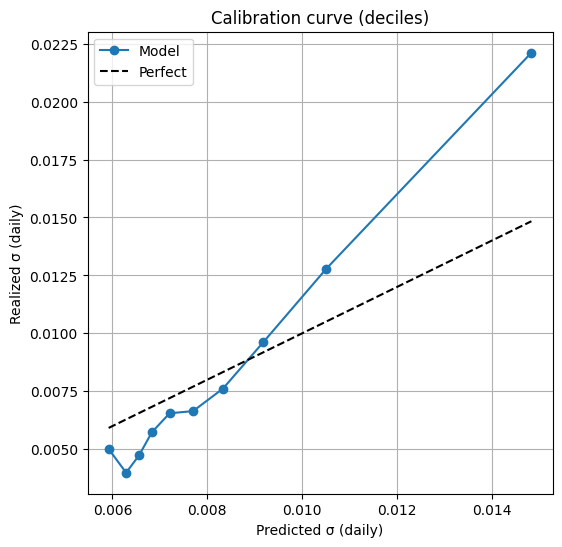

QLIKE — model: -6.786390 | baseline(past-H RV): -6.102065 | Δ=-0.684325 (↓ better)


In [12]:
# Align to test rows (from main OOF)
te_idx_reg = np.concatenate([te for _, te in splits])
oof_full = np.asarray(oof, dtype="float64"); y_full = np.asarray(y, dtype="float64")
oof_aligned = oof_full[te_idx_reg]; y_aligned = y_full[te_idx_reg]
keep = np.isfinite(oof_aligned) & np.isfinite(y_aligned)
oof_aligned = oof_aligned[keep]; y_aligned = y_aligned[keep]; te_idx_reg = te_idx_reg[keep]
print("[Align] test rows:", len(te_idx_reg))

# Calibration (deciles) in σ
rv_true = np.expm1(y_aligned); rv_pred = np.expm1(oof_aligned)
sigma_true = np.sqrt(np.maximum(rv_true, 0.0) / H)
sigma_pred = np.sqrt(np.maximum(rv_pred, 0.0) / H)
df_cal = pd.DataFrame({"σ_true": sigma_true, "σ_pred": sigma_pred})
df_cal["decile"] = pd.qcut(df_cal["σ_pred"], q=10, labels=False, duplicates="drop")
cal = df_cal.groupby("decile").agg(mean_pred=("σ_pred","mean"), mean_true=("σ_true","mean")).reset_index()

import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.plot(cal["mean_pred"], cal["mean_true"], "o-", label="Model")
plt.plot([cal["mean_pred"].min(), cal["mean_pred"].max()],
         [cal["mean_pred"].min(), cal["mean_pred"].max()],
         "k--", label="Perfect")
plt.xlabel("Predicted σ (daily)"); plt.ylabel("Realized σ (daily)")
plt.title("Calibration curve (deciles)"); plt.legend(); plt.grid(True); plt.show()

# QLIKE vs simple baseline: past-H realized variance
rv_back_H_all = (feat["ret_1"].astype(float)**2).rolling(H).sum().to_numpy()
rv_base = np.maximum(rv_back_H_all[te_idx_reg], 1e-12)
rv_true = np.maximum(np.expm1(y_aligned), 0.0)
rv_pred = np.maximum(np.expm1(oof_aligned), 0.0)

def qlike(y_true_rv, y_pred_rv, eps=1e-12):
    y_true = np.maximum(np.asarray(y_true_rv).reshape(-1), eps)
    y_pred = np.maximum(np.asarray(y_pred_rv).reshape(-1), eps)
    return float(np.mean(np.log(y_pred) + y_true / y_pred))

ql_model = qlike(rv_true, rv_pred)
ql_base  = qlike(rv_true, rv_base)
print(f"QLIKE — model: {ql_model:.6f} | baseline(past-H RV): {ql_base:.6f} | Δ={ql_model-ql_base:+.6f} (↓ better)")

In [13]:
assert models, "Train first."
last_X = (feat[X_cols].select_dtypes("number").astype("float32")
                    .replace([np.inf,-np.inf], np.nan).fillna(0.0)).iloc[[-1]]

bst = models[-1]
pred = float(bst.predict(
    xgb.DMatrix(np.ascontiguousarray(last_X.values, np.float32), feature_names=list(last_X.columns)),
    iteration_range=(0, bst.best_iteration+1)
)[0])

pred_rv = math.expm1(pred) if CFG["log1p_target"] else pred
print(f"Date: {feat['date'].iloc[-1]} | Pred log(1+RV_{H})={pred:.6f}  (RV≈{pred_rv:.6f})")

SAVE_DIR = CFG["model_out_dir"]
os.makedirs(SAVE_DIR, exist_ok=True)
for i, bst in enumerate(models, start=1):
    bst.save_model(f"{SAVE_DIR}/xgb_reg_fold{i}.json")
with open(f"{SAVE_DIR}/feature_order.txt","w") as f:
    f.write("\n".join(X_cols))
with open(f"{SAVE_DIR}/config.json","w") as f:
    json.dump(CFG, f, indent=2)
feat[["date","date_only", TARGET_COL, *X_cols]].tail(3)
print("Saved artifacts to:", SAVE_DIR)

Date: 2020-06-11 00:00:00 | Pred log(1+RV_5)=0.002023  (RV≈0.002025)
Saved artifacts to: /content/drive/MyDrive/models/vol_xgb


In [14]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

def _qlike(y_true_rv, y_pred_rv, eps=1e-12):
    y_true = np.maximum(np.asarray(y_true_rv).reshape(-1), eps)
    y_pred = np.maximum(np.asarray(y_pred_rv).reshape(-1), eps)
    return float(np.mean(np.log(y_pred) + (y_true / y_pred)))

def _align(y_full_logrv, pred):
    y_full = np.asarray(y_full_logrv).reshape(-1)
    p = np.asarray(pred).reshape(-1)
    n = min(len(y_full), len(p))
    y_use, p_use = y_full[:n], p[:n]
    m = np.isfinite(y_use) & np.isfinite(p_use)
    return y_use[m], p_use[m]

rows = []
for name, preds in [
    ("Tech-only", oof_t),
    ("Tech+News", oof_f),
    ("News-only", oof_news),
    ("HAR",       oof_har),
]:
    if preds is None: continue
    y_use, p_use = _align(y, preds)
    r2 = r2_score(y_use, p_use)
    ic = spearmanr(y_use, p_use).correlation
    ql = _qlike(np.expm1(y_use), np.expm1(p_use))
    rows.append({"Model": name, "n": len(y_use), "R2": r2, "IC": ic, "QLIKE": ql})

res_df = pd.DataFrame(rows).set_index("Model").sort_values("QLIKE")
res_df.style.format({"R2":"{:.3f}","IC":"{:.3f}","QLIKE":"{:.3f}","n":"{:d}"})

,n,R2,IC,QLIKE
Model,,,,
Tech+News,1274,0.110,0.600,-6.778
Tech-only,1274,0.077,0.597,-6.687
HAR,1274,-0.021,-0.192,-5.858
News-only,1274,-0.026,-0.088,-5.691
